In [36]:
import xgboost as xgb
import pandas as pd
import ast
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import glob

# 步驟 1: 加載和合併多個CSV文件中的數據
csv_files = glob.glob("*.csv")  # 修改為CSV文件的路徑
df_list = []

for file in csv_files:
    df = pd.read_csv(file)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    # 分割 '[N1, N1f, N1e]' 列為單獨的列
    # 分割 '[N2, N2f]' 列為單獨的列
    df[['N1', 'N1f', 'N1e']] = df['[N1, N1f, N1e]'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df[['N2', 'N2f']] = df['[N2, N2f]'].apply(lambda x: pd.Series(ast.literal_eval(x)))

    # 刪除原始的分割列
    df = df.drop(columns=['[N1, N1f, N1e]', '[N2, N2f]'])

    # 將處理過的DataFrame加入列表
    df_list.append(df)

# 合併所有數據框
combined_df = pd.concat(df_list, ignore_index=True)

# # 處理合併數據集中的缺失值或不一致性
# combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
# combined_df = combined_df.dropna()


# 生成派生特徵
combined_df["N1f_ratio"] = combined_df["N1f"] / (combined_df["N1"] + 1e-8)
combined_df["N1e_ratio"] = combined_df["N1e"] / (combined_df["N1"] + 1e-8)
combined_df["N1_remain_f"] = combined_df["N1"] - combined_df["N1f"]
combined_df["N1_remain_e"] = combined_df["N1"] - combined_df["N1e"]
combined_df["N1f_plus_e"] = combined_df["N1f"] + combined_df["N1e"]
combined_df["N1f_e_ratio"] = combined_df["N1f"] / (combined_df["N1e"] + 1e-8)
combined_df["N2f_ratio"] = combined_df["N2f"] / (combined_df["N2"] + 1e-8)
combined_df["N2_remain_f"] = combined_df["N2"] - combined_df["N2f"]

# 選取特徵X及標籤y欄位
X = combined_df[["N1", "N1f", "N1e", "N2", "N2f", "P", "SFratio", "CoolerdT", "N1f_ratio", "N1e_ratio", "N1_remain_f", "N1_remain_e", "N1f_plus_e", "N1f_e_ratio", "N2_remain_f", "N2f_ratio"]]  # 你要用來預測的輸入變數
y = combined_df["Cost"]  # 你想預測的目標（例如：成本）

# print(X)

# 切分訓練和測試數據
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 轉換數據格式為DMatrix
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

# 設置參數
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10
}

# 訓練模型
xg_reg = xgb.train(params=params, dtrain=train_dmatrix, num_boost_round=100)

# 預測
preds = xg_reg.predict(test_dmatrix)

# 計算均方誤差
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse}")

RMSE: 58431.842755534664


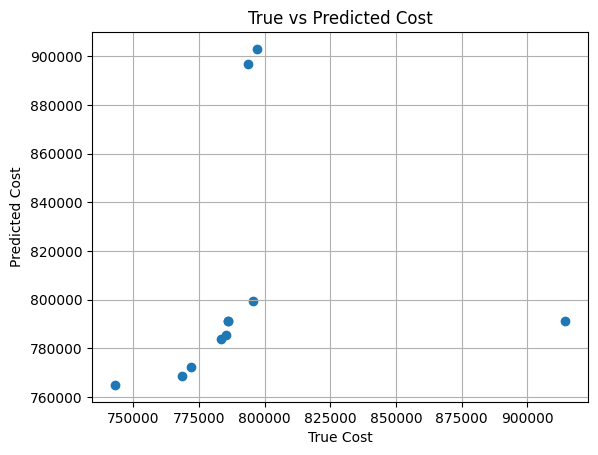

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

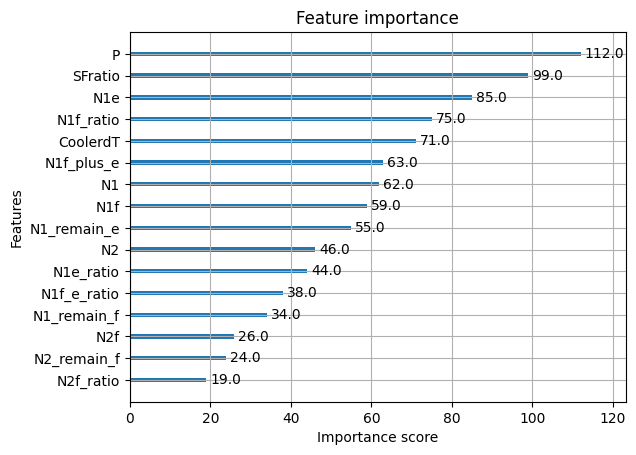

In [37]:
import matplotlib.pyplot as plt
plt.scatter(y_test, preds)
plt.xlabel("True Cost")
plt.ylabel("Predicted Cost")
plt.title("True vs Predicted Cost")
plt.grid()
plt.show()
xgb.plot_importance(xg_reg)